# Face Recognition using Convolutional Neural Network (CNN)

This notebook implements a face recognition system using a Convolutional Neural Network. 
The goal is to classify a face image and identify which person it
belongs to.
The model directly learns to classify identities from labeled face images.

The dataset consists of multiple face images per person, organized into folders where
each folder represents one individual.

## Importing Required Libraries

We import the following libraries:
- os: for navigating through folders
- cv2: for reading and processing images
- numpy: for numerical operations
- matplotlib: for plotting graphs
- sklearn: for dataset splitting and evaluation
- tensorflow / keras: for building and training the CNN


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

2026-01-15 19:38:16.672593: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-15 19:38:16.757773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 19:38:19.036739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 19:39:07.192958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Dataset Configuration

- The dataset is stored inside `cnn_model/dataset/images`
- Each folder inside this directory represents one person
- All images are converted to grayscale
- Image size is fixed to 64 × 64 pixels

In [17]:
DATASET_PATH = "../dataset/images"

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
IMAGE_CHANNELS = 1

BATCH_SIZE = 16
EPOCHS = 40

## Loading the Dataset

In this step:
- We iterate over each person folder
- Each folder name is treated as a class label
- Each image is read, resized, and converted to grayscale
- Labels are assigned manually using an integer counter


In [18]:
images = []
labels = []
label_names = []

current_label = 0

print("Starting dataset loading...\n")

for folder_name in os.listdir(DATASET_PATH):

    folder_path = os.path.join(DATASET_PATH, folder_name)

    if os.path.isdir(folder_path) == False:
        continue

    print("Processing class:", folder_name)
    label_names.append(folder_name)

    for file_name in os.listdir(folder_path):

        if file_name.lower().endswith(".jpg") == False and \
           file_name.lower().endswith(".png") == False and \
           file_name.lower().endswith(".jpeg") == False:
            continue

        image_path = os.path.join(folder_path, file_name)

        image = cv2.imread(image_path)

        if image is None:
            continue

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(gray_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        images.append(resized_image)
        labels.append(current_label)

    current_label = current_label + 1

print("\nDataset loading completed.")

Starting dataset loading...

Processing class: Akshay Kumar
Processing class: Alexandra Daddario
Processing class: Alia Bhatt
Processing class: Amitabh Bachchan
Processing class: Andy Samberg
Processing class: Anushka Sharma
Processing class: Billie Eilish
Processing class: Brad Pitt
Processing class: Camila Cabello
Processing class: Charlize Theron
Processing class: Claire Holt
Processing class: Courtney Cox
Processing class: Dwayne Johnson
Processing class: Elizabeth Olsen
Processing class: Ellen Degeneres
Processing class: Henry Cavill
Processing class: Hrithik Roshan
Processing class: Hugh Jackman
Processing class: Jessica Alba
Processing class: Kashyap
Processing class: Lisa Kudrow
Processing class: Margot Robbie
Processing class: Marmik
Processing class: Natalie Portman
Processing class: Priyanka Chopra
Processing class: Robert Downey Jr
Processing class: Roger Federer
Processing class: Tom Cruise
Processing class: Vijay Deverakonda
Processing class: Virat Kohli
Processing class:

## Data Conversion and Normalization

- Lists are converted to NumPy arrays
- Pixel values are normalized to the range [0, 1]
- Data is reshaped to match CNN input format

In [19]:
images = np.array(images)
labels = np.array(labels)

images = images / 255.0

images = images.reshape(
    images.shape[0],
    IMAGE_HEIGHT,
    IMAGE_WIDTH,
    IMAGE_CHANNELS
)

## Label Encoding

Neural networks require categorical labels.
We convert numeric labels into one-hot encoded format.

In [20]:
number_of_classes = len(label_names)
labels = to_categorical(labels, number_of_classes)

## Train-Test Split

The dataset is split into:
- 80% training data
- 20% testing data

This ensures the model is evaluated on unseen images.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## CNN Architecture

The CNN consists of:
- Three convolution layers
- Max pooling after each convolution
- Fully connected dense layers
- Softmax output layer for classification

In [22]:
model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu"
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(3, 3),
        activation="relu"
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(number_of_classes, activation="softmax"))

/mnt/d/Smart_Attendence_System/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Compilation

- Optimizer: Adam
- Loss function: Categorical Crossentropy
- Metric: Accuracy

In [23]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Model Training

The model is trained for a fixed number of epochs.
Validation split is used to monitor overfitting.

In [24]:
training_history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1
)

Epoch 1/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.0352 - loss: 3.4335 - val_accuracy: 0.0293 - val_loss: 3.4182
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0466 - loss: 3.4044 - val_accuracy: 0.0585 - val_loss: 3.3906
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.0743 - loss: 3.3260 - val_accuracy: 0.0683 - val_loss: 3.3095
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1090 - loss: 3.1496 - val_accuracy: 0.1024 - val_loss: 3.2039
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1692 - loss: 2.9408 - val_accuracy: 0.1073 - val_loss: 3.0821
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2137 - loss: 2.6959 - val_accuracy: 0.1317 - val_loss: 2.9912
Epoch 7/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.2993 - loss: 2.4316 - val_accuracy: 0.1122 - val_loss: 2.9343
Epoch 8/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3726 - loss: 2.1179 - val_accu

## Training Performance Visualization

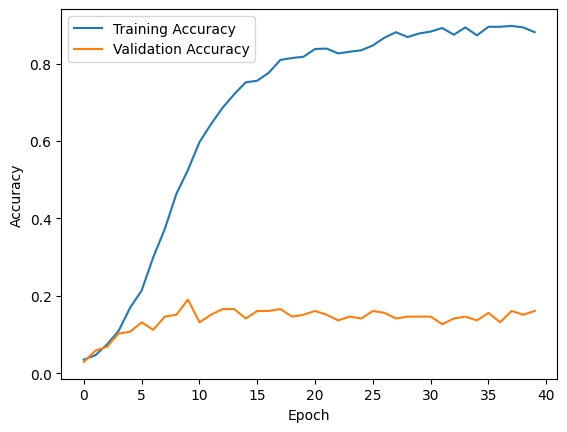

In [25]:
plt.figure()
plt.plot(training_history.history["accuracy"])
plt.plot(training_history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

## Model Evaluation on Test Data

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1657 - loss: 6.0298
Test Accuracy: 0.16569200158119202


In [27]:
predictions = model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes, target_names=label_names))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 1 0 3 0 0 0 1 0 0 0 1 1 1 0 0 0 0 4 1 0 0 0 0 0 0]
 [0 1 2 0 0 1 1 0 2 0 0 2 0 1 0 0 0 0 2 0 0 1 0 0 6 0 0 0 0 0 0]
 [0 0 0 3 1 0 0 4 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 2 0 3 0 1]
 [1 0 0 0 2 0 1 1 0 1 1 0 1 0 0 1 1 2 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 1 2 0 1 1 2 0 0 0 0 2 1 0 1 1 0 1 0 0 0 0 0 2 1 0 1 0 1 0 1]
 [0 0 2 0 3 0 7 0 2 0 1 0 0 2 2 0 1 0 0 0 0 1 0 0 2 1 0 0 0 0 0]
 [0 1 0 0 3 1 0 3 1 0 0 1 1 2 1 2 1 2 0 0 0 0 0 0 1 4 2 0 1 0 2]
 [0 2 0 0 1 0 1 0 6 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 2 3 0 0 3 0 0 0 0 0 0 1 0 0 3 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 5 0 0 0 0 1 0 0 0 0 0 4 0 3 0 1 0 0 1 0 0]
 [0 2 0 1 0 1 0 0 3 0 0 0 0 0 0 1 2 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 1 0 0 2 0 1 0 0 0 0 0 1 0 0 3 0 0 0 0 3 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 1 2 1 1 4 1 0 0 4 0 0 1 1 0 0 1 0 0 

## Saving the Trained Model

In [28]:
model.save("../models/face_recognition_cnn.h5")
print("Model saved successfully.")

Model saved successfully.
